In [1]:
import matplotlib.pyplot as plt 
import xopen, orjson
import pandas as pd 
pd.options.display.max_colwidth = 250
pd.options.display.html.use_mathjax = False

def read_discourse_df(filename):
    output = []
    with xopen.xopen(filename) as f:
        for line in f:
            line_dict = orjson.loads(line)
            output.append(pd.DataFrame(line_dict))

    return pd.concat(output)

def read_compressed_jsonl(filename):
    """Read compressed jsonl file and catch errors."""
    output = []
    try:
        with xopen.xopen(filename) as f:
            for line in f:
                try:
                    line_dict = orjson.loads(line)
                    output.append(line_dict)
                except:
                    continue
    except:
        pass
    return pd.DataFrame(output)

# Bloomberg

In [111]:
outfile = '../models/factual-consistency/data/bloomberg-entailment-data-bartscore.jsonl.gz'
discourse_filename = '../data/bloomberg-articles/news-discourse.jsonl.gz'
scored_articles_df = (
    pd.read_json(outfile, compression='gzip', orient='records', lines=True)
        .assign(is_match=lambda df: df['model_prediction'] > .03)
        .assign(source='bloomberg')
)

discourse_df = read_discourse_df(discourse_filename)

scored_article_has_match = (
    scored_articles_df
        .groupby(['doc_idx', 'article_sent_idx', 'article_sentence'])
        ['is_match'].mean().pipe(lambda s: (s>0).astype(int))
        .reset_index()
)

scored_df_with_discourse = (
    discourse_df
     .merge(
        scored_article_has_match, 
        left_on=['doc_id', 'sentences'], 
        right_on=['doc_idx', 'article_sentence']
     )
     .drop(columns=['sentences'])
)

In [114]:
(scored_articles_df
 .loc[lambda df: df['is_match']]
 [['article_sentence', 'archive_headline']]
 .drop_duplicates('article_sentence')
 .head(2)
)

,article_sentence,archive_headline
81,"Alliance shareholders will be paid in shares in Qantas, which already owns 20% of the company.",Qantas Agrees to Acquire the Rest of Alliance Aviation
248,"Peloton also said about 2,800 global jobs would be cut, affecting around 20% of corporate positions.","Peloton Confirms Reduction of About 2,800 Global Positions"


Text(0.5, 1.0, 'Bloomberg Articles/Bloomberg Archive')

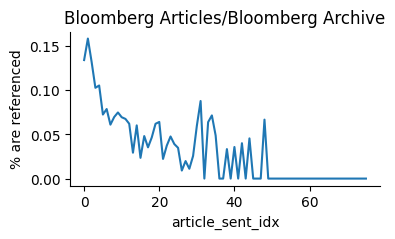

In [118]:
g = scored_article_has_match.groupby('article_sent_idx')['is_match']
ax = g.mean().plot(figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('% are referenced')
plt.title('Bloomberg Articles/Bloomberg Archive')

Text(0.5, 1.0, 'Bloomberg Articles/Bloomberg Archive')

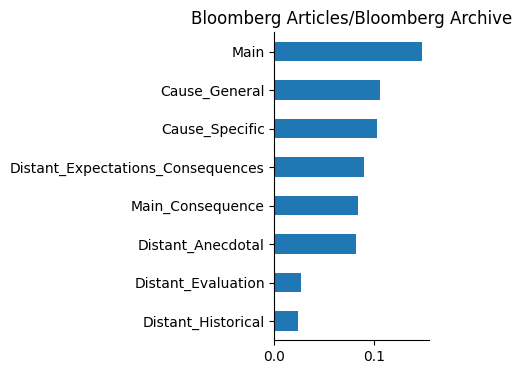

In [110]:
ax = (scored_df_with_discourse.groupby('discourse_preds')['is_match']
 .mean()
 .sort_values(ascending=False)
 .iloc[::-1]
 .plot(kind='barh', figsize=(2,4))
)
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Bloomberg Articles/Bloomberg Archive')

# New York Times

In [2]:
nyt_outfile = '../models/factual-consistency/data/nytimes-entailment-data.jsonl.gz'
nyt_scored_articles_df = (
    read_compressed_jsonl(nyt_outfile)
#         .assign(is_match=lambda df: df['model_prediction'] > .03)
#         .assign(source='nyt')
)

<Axes: >

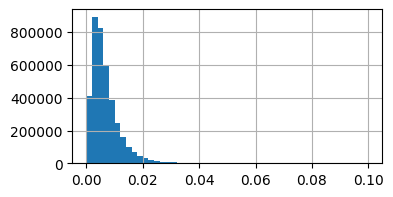

In [130]:
nyt_scored_articles_df['model_prediction'].hist(bins=50, figsize=(4,2), range=(0, .1))

In [3]:
nyt_scored_articles_df['article_sentence'].drop_duplicates().shape 

(10573,)

In [6]:
nyt_scored_articles_df['model_prediction'].argmax()

1900776

In [26]:
top_matched_articles = (
    nyt_scored_articles_df
     .groupby(['doc_idx', 'article_sent_idx'])
     .apply(lambda df: df.loc[df['model_prediction'].idxmax()])
     .reset_index(drop=True)
)

<Axes: >

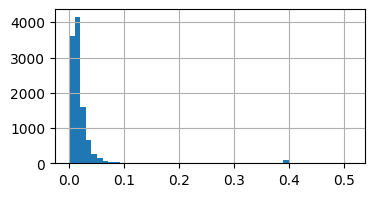

In [34]:
top_matched_articles['model_prediction'].hist(bins=50, figsize=(4,2))

In [117]:
top_matched_articles.loc[lambda df: df['model_prediction']  > .03][['article_sentence', 'archive_headline']]

,article_sentence,archive_headline
4,"The average for a socially screened index fund is 0.85 percent, according to Morningstar.",The average actively managed United States stock fund tracked by Morningstar has an expense ratio of 1.23 percent.
12,You may opt-out at any time.,You may opt-out at any time.
18,It now includes the 450 largest stocks in the S.& P. 500.,"Only 54 of the stocks in the S.& P. 500 rose, while 416 fell."
23,"Mr. Milloy has decided that if you can't beat 'em, join 'em.",Mr. Cullman took out a full-page ad to protest.
28,"He retired a few years ago from the Altria Group, which was formerly known as Philip Morris.","Last year, the Altria Group, as the parent company was renamed, reported net earnings of $9.2 billion on revenue of $81.8 billion."
...,...,...
10658,"European indexes were all higher, with the FTSE 100 in Britain up more than 1 percent and the Dax in Germany slightly higher.","The Dow Jones industrial average lost 57.94 points, or 0.3 percent, to 17,675.16."
10659,"Most Asian markets closed higher; in Hong Kong, the Hang Seng gained 0.4 percent, and in South Korea, the Kospi rose 0.7 percent.","The Dow Jones industrial average lost 57.94 points, or 0.3 percent, to 17,675.16."
10661,"Industrial output rose 5.6 percent in August, the most in eight months, and retail sales grew 0.5 percent from a year ago, for the first time this year.","Pressured by trade, rising interest rates in the United States and a stronger American dollar, the MSCI Emerging Market Index fell about 20 percent this year to its low in October."
10663,"Industrial production in the United States rose 0.4 percent in August, data released by the Federal Reserve on Tuesday showed.",Economists expect that consumer prices ticked up more slowly last month thanks to a drop in gas prices.


# How accurate are the parsed dates?

In [1]:
from subprocess import Popen, PIPE
def get_wayback_urls(site):
    output, err = Popen([
        "waybackpack",
        site,
        "--list",
        '--user-agent',
        'waybackpack-spangher@usc.edu'
    ], stdin=PIPE, stdout=PIPE, stderr=PIPE).communicate()
    return output.decode().strip().split()

In [2]:
import pandas as pd 

In [35]:
# ls ../data/open-sourced-articles/
import pandas as pd 
barrons = pd.read_json(
    '../data/open-sourced-articles/barrons-business-articles-sans-html.jsonl.gz',
    compression='gzip',
    lines=True,
    nrows=10000
)

In [15]:
cc_to_web_map = {
    'com,forbes': 'https://www.forbes.com',
    'com,barrons': 'https://www.barrons.com',
    'com,foxbusiness': 'https://www.foxbusiness.com',
    'com,businessinsider': 'https://www.businessinsider.com',
    'com,cnbc': 'https://www.cnbc.com',
    'com,marketwatch': 'https://www.marketwatch.com',
    'com,nytimes': 'https://www.nytimes.com',
    'com,reuters': 'https://www.reuters.com',
    'com,techcrunch': 'https://techcrunch.com',
    'com,washingtonpost': 'https://www.washingtonpost.com',
    'com,wsj': 'https://www.wsj.com'
}

In [93]:
from tqdm.auto import tqdm

In [24]:
barron_urls = (
    barrons['article_url']
    .apply(lambda x: x.split(')'))
    .apply(lambda x: 
            cc_to_web_map[x[0]] + x[-1]
          )
        .drop_duplicates()
)

In [41]:
from tqdm.auto import tqdm
url_timestamp = {}
for url in tqdm(barron_urls):
    timestamps = get_wayback_urls(url)
    if len(timestamps) > 0:
        url_timestamp[url] = timestamps[0]
    else:
        url_timestamp[url] = 'Not Found'
    break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
url_timestamp

In [98]:
url_timestamp_s = pd.Series(url_timestamp)

In [101]:
url_timestamp_s.pipe(lambda s: s=='Not Found').value_counts()

False    247
True      52
Name: count, dtype: int64

In [ ]:
(url_timestamp_s
 .loc[lambda s: s != 'Not Found']
 .str.split('/')
 .str.get(4)
)

In [109]:
t.split('/')[4]

'20220304232246'

# Build Archive

In [271]:
all_articles_df = (
    load_jsonl_fault_tolerant('../data/open-sourced-articles/nytimes-articles-parsed.jsonl.gz')
        .loc[lambda df: df['ents'].str.len() > 0]
)

press_release_articles_df = (
    load_jsonl_fault_tolerant('../data/open-sourced-articles/nytimes-articles-links.jsonl.gz')
        .loc[lambda df: df['ents'].str.len() > 0]
        .reset_index(drop=True)
)

In [157]:
all_ents = pd.concat([
    all_articles_df['ents'],
    press_release_articles_df['ents']
])

In [169]:
cv = CountVectorizer(analyzer=lambda x: x)
vec = cv.fit_transform(all_ents.apply(set).apply(list))

In [194]:
top_terms = (
    pd.DataFrame(vec.todense(), columns=sorted(cv.vocabulary_))
        .sum()
        .sort_values(ascending=False)
        .pipe(lambda s : s/len(all_ents))
        .head(20)
)

In [209]:
all_articles_df['ents'] = (
    all_articles_df['ents']
       .apply(lambda x: x if isinstance(x, (list, set)) else [])
       .apply(lambda x: list(set(x) - set(top_terms.index)))
)

press_release_articles_df['ents'] = (
    press_release_articles_df['ents']
       .apply(lambda x: x if isinstance(x, (list, set)) else [])
       .apply(lambda x: list(set(x) - set(top_terms.index)))
)

In [259]:
target_ents = press_release_articles_df['ents'].pipe(lambda s: set(list(flatten(s.tolist()))))
relevant_archival_articles = (
    all_articles_df
     .loc[lambda df: df['ents'].apply(lambda x: len(set(x) - target_ents) > 0)]
     .reset_index(drop=True)
)

In [260]:
ent_vecs = cv.fit_transform(pd.concat([
    relevant_archival_articles['ents'],
    press_release_articles_df['ents']
]))

archive_ent_vecs = ent_vecs[:len(relevant_archival_articles)]
pr_ent_vecs = ent_vecs[len(relevant_archival_articles):]

sims = cosine_similarity(archive_ent_vecs, Y=pr_ent_vecs)
x, y = np.where(sims > 0)

In [280]:
archive_article_map = pd.concat([
    relevant_archival_articles['article_url']
        .iloc[x]
        .reset_index(drop=True)
        .to_frame('archival_url'),
    press_release_articles_df['article_url']
        .iloc[y]
        .reset_index(drop=True)
        .to_frame('target_article_url')
], axis=1)

In [286]:
for url in archive_article_map.unstack().drop_duplicates().reset_index(drop=True):
    

0                                  com,nytimes)/video/business/1194817103719/com,nytimes)/video/business/1194817103719/executive-pursuits.html
1                        com,nytimes)/interactive/2019/03/29/business/com,nytimes)/interactive/2019/03/29/business/boeing-737-max-8-flaws.html
2             com,nytimes)/video/business/100000004384054/com,nytimes)/video/business/100000004384054/takata-recall-largest-in-us-history.html
3                          com,nytimes)/video/business/1194817108502/com,nytimes)/video/business/1194817108502/enron-anatomy-of-a-scandal.html
4       com,nytimes)/2015/10/21/business/com,nytimes)/2015/10/21/business/tommy-hilfiger-introduces-virtual-reality-headsets-for-shoppers.html
                                                                         ...                                                                  
6483                                                com,nytimes)/2018/10/25/business/com,nytimes)/2018/10/25/business/cathay-pacific-hack.html

In [ ]:
press_release_articles_df['article_url'].iloc[x]

In [121]:
ls ../data/open-sourced-articles/nytimes-articles-links.jsonl.gz

../data/open-sourced-articles/nytimes-articles-links.jsonl.gz


In [43]:
import requests
'http://web.archive.org/cdx/search/cdx?url=archive.org&fl=timestamp,mimetype&output=json'

In [80]:
SEARCH_URL = "https://web.archive.org/cdx/search/cdx"
res = requests.get(
    SEARCH_URL,
    params={
        "url": 'https://www.nytimes.com',
        "fl": "timestamp",
        "limit": "5",
    },
    headers = {
        "User-Agent": 'spangher@usc.edu',
    }
)

In [78]:
r = res.text

In [79]:
sorted(r.split())

['19961112181513',
 '19961112181513',
 '19961112181513',
 '19961121230155',
 '19961219002950']

In [74]:
res.text

'19961112181513\n19961112181513\n19961112181513\n19961121230155\n19961219002950\n'

In [86]:
import json

In [87]:
t = requests.post(
    'https://us-west1-usc-research.cloudfunctions.net/wayback-timestamp',
    headers={
        'Content-Type': 'application/json'
    },
    data=json.dumps({'article_url': 'nytimes.com'})
)

In [89]:
t.text

'19961112181513'

In [90]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [91]:
s = [4, 1, 15, 1, 13, 3, 14, 1, 23, 6, 19, 4]

In [95]:
''.join(list(map(lambda x: alphabet[x], s)))

'ebpbndobxgte'